In [ ]:
import sys

sys.path.append("slimpajama/py_src/near_duplicates")

In [ ]:
import os
import pickle
from transformers import GPT2Tokenizer
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from collections import Counter
import json
from utils import edit_distance
import json
import pandas as pd
from config import BASE_DIR


In [ ]:
PATHS = {
    "replacement": "results_to_compute_rho_vs_levensthein_replacement.pickle",
    "insertion": "results_to_compute_rho_vs_levensthein_insertion.pickle",
    "shuffle": "results_to_compute_rho_vs_levensthein_shuffle.pickle",
}

SLIMPAJAMA_RHO = {
    '1-10': 0.708,
    '11-20': 0.426,
    '21-30': 0.666,
    '31-40': 0.222,
    '41-50': 0.319
}

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [ ]:
def lcs_length(a, b):
    table = [[0] * (len(b) + 1) for _ in range(len(a) + 1)]
    for i, ca in enumerate(a, 1):
        for j, cb in enumerate(b, 1):
            table[i][j] = (
                table[i - 1][j - 1] + 1 if ca == cb else
                max(table[i][j - 1], table[i - 1][j]))
    # return max(len(a),len(b)) - table[-1][-1]
    return len(a) + len(b) - 2*table[-1][-1]

def damerau_levenshtein_distance(a, b):
    """
    Compute the Damerau-Levenshtein distance between two sequences.
    This includes insertions, deletions, substitutions, and transpositions.
    """
    len_a, len_b = len(a), len(b)
    
    da = {}
    
    max_dist = len_a + len_b
    H = [[max_dist for _ in range(len_b + 2)] for _ in range(len_a + 2)]
    
    H[0][0] = max_dist
    for i in range(0, len_a + 1):
        H[i + 1][0] = max_dist
        H[i + 1][1] = i
    for j in range(0, len_b + 1):
        H[0][j + 1] = max_dist
        H[1][j + 1] = j
    
    for i in range(1, len_a + 1):
        db = 0
        for j in range(1, len_b + 1):
            i1 = da.get(b[j - 1], 0)
            j1 = db
            cost = 1
            if a[i - 1] == b[j - 1]:
                cost = 0
                db = j
            
            H[i + 1][j + 1] = min(
                H[i][j] + cost,  # substitution
                H[i + 1][j] + 1,  # insertion
                H[i][j + 1] + 1,  # deletion
                H[i1][j1] + (i - i1 - 1) + 1 + (j - j1 - 1)  # transposition
            )
        
        da[a[i - 1]] = i
    
    return H[len_a + 1][len_b + 1]


def token_overlap(a,b):
    counter_a = Counter(a)
    counter_b = Counter(b)
    overlap = sum((counter_a & counter_b).values())
    return 1 - (overlap / (max(len(a),len(b))))

def jaccard_token(a,b):
    set_a = set(a)
    set_b = set(b)
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    return 1 - (intersection / union) if union > 0 else 0

def jaccard_ngram(a,b,n=13):
    ngrams_a = set()
    ngrams_b = set()
    
    for i in range(len(a) - n + 1):
        ngram = tuple(a[i:i+n])
        ngrams_a.add(ngram)
    
    for i in range(len(b) - n + 1):
        ngram = tuple(b[i:i+n])
        ngrams_b.add(ngram)
    
    intersection = len(ngrams_a & ngrams_b)
    union = len(ngrams_a | ngrams_b)
    return 1 - (intersection / union) if union > 0 else 0
    

DISTANCES = {
    "edit": edit_distance,
    "damerau": damerau_levenshtein_distance,
    "lcs": lcs_length,
    "token_overlap": token_overlap,
    "jaccard_token": jaccard_token,
    "jaccard_ngram": jaccard_ngram,
}

In [ ]:
data = {}
for name, filename in PATHS.items():
    filepath = os.path.join(BASE_DIR, filename)
    with open(filepath, 'rb') as f:
        data[name] = pickle.load(f)
    print(f"Loaded {name}: {len(data[name])} items")

with open('final_canaries_to_export.json', 'r') as f:
    final_canaries = json.load(f)


data["slimpajama"] = defaultdict(dict)
for levenstein_range in final_canaries:
    fuzzy_duplicates = []
    data["slimpajama"][levenstein_range]["mean_rho"] = SLIMPAJAMA_RHO[levenstein_range]
    for k_bucket in final_canaries[levenstein_range]:
        for x in final_canaries[levenstein_range][k_bucket]:
            d = {
                "original": x["og_tokens"],
                "variations": []
            }
            for fuzzy_dup in x["fuzzy_duplicates"]:
                d["variations"].append(fuzzy_dup["tokens"])
            fuzzy_duplicates.append(d)
    pickle_path = f"{levenstein_range}_slimpajama_canaries.pickle"

    with open(pickle_path, 'wb') as f:
        pickle.dump(fuzzy_duplicates, f)

    data["slimpajama"][levenstein_range]["paths_to_fuzzy"] = [pickle_path]


In [ ]:
plot_data = {}

for perturb in data:
    plot_data[perturb] = defaultdict(list)
    for _, v in data[perturb].items():
        rho = v["mean_rho"]
        distances = defaultdict(list)

        for fuzzy_path in v["paths_to_fuzzy"]:
            with open(fuzzy_path, 'rb') as f:
                fuzzy_data = pickle.load(f)
            
            for canary in fuzzy_data:
                og_tokens = canary["original"]

                for variation in canary["variations"]:
                    if "tokens" in variation:
                        tokens = variation["tokens"]
                    else:
                        tokens = variation
                    
                    for dist in DISTANCES:
                        dist_fn = DISTANCES["lcs"]
                        distances[dist].append(dist_fn(og_tokens, tokens))

        for dist in DISTANCES:
            res = (rho, np.mean(distances[dist]))
            plot_data[perturb][dist].append(res)
            print(dist, res)

with open('plot_data.pickle', 'wb') as f:
    pickle.dump(plot_data, f)
print("Saved plot_data to plot_data.pickle")


In [ ]:
with open('plot_data.pickle', 'rb') as f:
    plot_data = pickle.load(f)
print("Loaded plot_data from plot_data.pickle")


Saved data to distances_scatter_all.csv


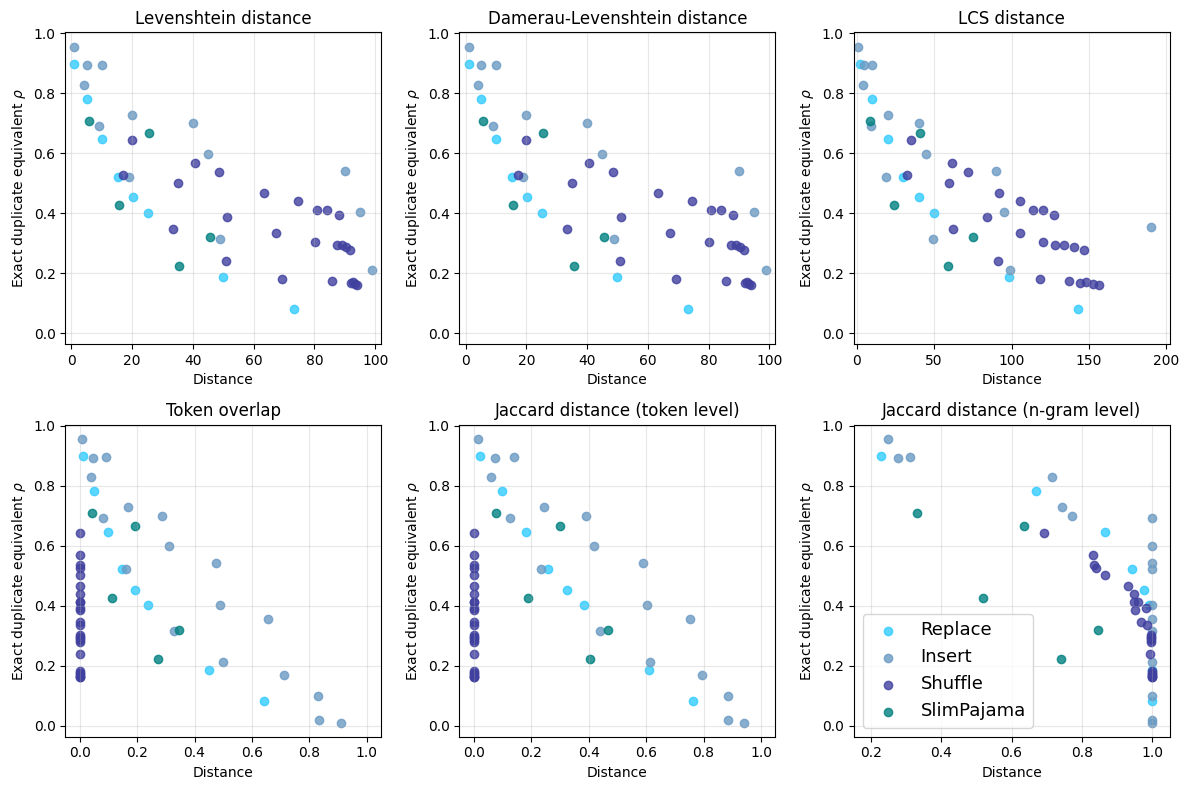

In [ ]:
LABELS={
    "replacement": "Replace",
    "insertion": "Insert",
    "shuffle": "Shuffle",
    "slimpajama": "SlimPajama",
}

COLORS={
    "replacement": "#32ccff",
    "insertion": "#6b9ac3",
    "shuffle": "#40409f",
    "slimpajama": "teal",
}

METRIC_LABELS = {
    "edit": "Levenshtein distance",
    "damerau": "Damerau-Levenshtein distance",
    "lcs": "LCS distance",
    "token_overlap": "Token overlap",
    "jaccard_token": "Jaccard distance (token level)",
    "jaccard_ngram": "Jaccard distance (n-gram level)",
}

n_metrics = len(plot_data["replacement"])
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

csv_data = []

for perturb in plot_data:
    for i, (metric, data_points) in enumerate(plot_data[perturb].items()):
        if i < len(axes):
            y_vals = [point[0] for point in data_points]
            x_vals = [point[1] for point in data_points]

            for x, y in zip(x_vals, y_vals):
                csv_data.append({'perturb': perturb, 'metric': metric, 'x_vals': x, 'y_vals': y})

            axes[i].scatter(x_vals, y_vals, alpha=0.8, label=LABELS[perturb], color=COLORS[perturb])
            axes[i].set_title(METRIC_LABELS[metric])
            axes[i].set_ylabel('Exact duplicate equivalent $\\rho$')
            axes[i].set_xlabel('Distance')
            axes[i].grid(True, alpha=0.3)

df = pd.DataFrame(csv_data)
df = df.round(2)
df.to_csv('distances_scatter_all.csv', index=False, sep=';', decimal=',')
print("Saved data to distances_scatter_all.csv")

axes[-1].legend(fontsize=13)
axes[0].set_xlim(-2, 102)
axes[1].set_xlim(-2, 102)
axes[2].set_xlim(-2, 202)
axes[3].set_xlim(-0.05, 1.05)
axes[4].set_xlim(-0.05, 1.05)
axes[5].set_xlim(.15, 1.05)

plt.tight_layout()
plt.savefig("distances_scatter_all.pdf", bbox_inches="tight")
plt.show()


Saved data to levenshtein_distance_data.csv


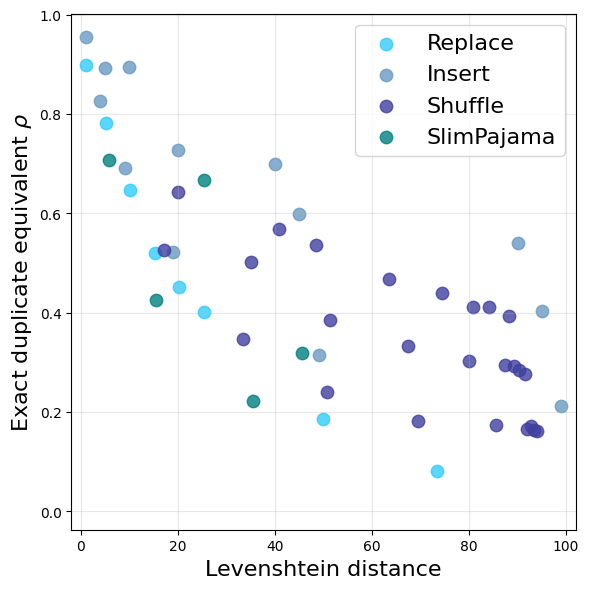

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

csv_data = []

for perturb in plot_data:
    data_points = plot_data[perturb]["edit"]
    y_vals = [point[0] for point in data_points]
    x_vals = [point[1] for point in data_points]

    for x, y in zip(x_vals, y_vals):
        csv_data.append({'perturb': perturb, 'x_vals': x, 'y_vals': y})
            
    ax.scatter(x_vals, y_vals, alpha=0.8, label=LABELS[perturb], color=COLORS[perturb], s=80)
    ax.set_ylabel('Exact duplicate equivalent $\\rho$', fontsize=16)
    ax.set_xlabel('Levenshtein distance', fontsize=16)
    ax.grid(True, alpha=0.3)

df = pd.DataFrame(csv_data)
df = df.round(2)
df.to_csv('distances_scatter_levenstein.csv', index=False, sep=';', decimal=',')
print("Saved data to levenshtein_distance_data.csv")

ax.legend(fontsize=16)
ax.set_xlim(-2, 102)

plt.tight_layout()
plt.savefig("distances_scatter_levenstein.pdf", bbox_inches="tight")
plt.show()